# Machine Learning Engineer Nanodegree
## Capstone Project - Starbucks app data

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [78]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Step 1 - Data preparation

### Portfolio

This dataset is pretty straightforward, we have a list of 10 offers with the specific informations.

_Data preparation:_
- Create a set of flags to split the _channels_ feature.
- Create a _channels_ counter.

In [79]:
rows, cols = portfolio.shape
print(f'There are {rows} rows and {cols} columns.\n')
portfolio

There are 10 rows and 6 columns.



,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [80]:
# Create a 0/1 flag for each channel
for channel in ['web', 'email', 'mobile', 'social']:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
portfolio['channels_num'] = portfolio['channels'].apply(lambda x: len(x))

portfolio.drop('channels', 1, inplace=True)

portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,channels_num
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,3
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,4
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,3
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,3
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,2
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,4
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,4
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,3
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,4
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,3


### Profile

This dataset has information about customers.

_Data preparation:_
- Transform the _became_member_on_ feature into a date feature.
- Analyse the missing features and eventually apply a transformation.

In [81]:
rows, cols = profile.shape
print(f'There are {rows} rows and {cols} columns.\n')
profile.head()

There are 17000 rows and 5 columns.



,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [82]:
cust = len(profile['id'].unique().tolist())
print(f'On {len(profile)} records we have {cust} customers')

On 17000 records we have 17000 customers


It seems that there are no duplicates.

In [83]:
# To transform the feature, we create a new column
profile['member_on'] = pd.to_datetime(profile['became_member_on'].astype(str)).dt.date
profile.drop('became_member_on', 1, inplace=True)

There are some missing values in _gender_ and _income_: let's dive in this subset.

In [84]:
profile.loc[profile['gender'].isnull()].describe()

,age,income
count,2175.0,0.0
mean,118.0,NaN
std,0.0,NaN
min,118.0,NaN
25%,118.0,NaN
50%,118.0,NaN
75%,118.0,NaN
max,118.0,NaN


It seems like _income_ is always null and _age_ is always 118. Since we basically have no info on these profiles, we can safely drop them.

In [85]:
profile = profile.loc[profile['gender'].isnull() == False]

rows, cols = profile.shape
print(f'After data preparation, we have {rows} rows and {cols} columns.\n')
profile.head(10)

After data preparation, we have 14825 rows and 5 columns.



,gender,age,id,income,member_on
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017-09-11
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014-02-13
15,F,62,31dda685af34476cad5bc968bdb01c53,71000.0,2016-02-11
16,M,49,62cf5e10845442329191fc246e7bcea3,52000.0,2014-11-13
18,M,57,6445de3b47274c759400cd68131d91b4,42000.0,2017-12-31


### Transcript

This dataframe contains the list of all actions on offers and transactions, with the relative information about money and time.

_Data preparation:_
- Analyse the _value_ feature and extract the information
- Reconstruct the customer journey, from receiving the offer to the (eventual) transaction

In [86]:
rows, cols = transcript.shape
print(f'There are {rows} rows and {cols} columns.\n')
transcript.head(10)

There are 306534 rows and 4 columns.



,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [87]:
keys = transcript['value'].apply(lambda x: str(list(x.keys())))
print(f'The values found in the dataset are {keys.unique()}')

pd.crosstab(keys, transcript['event'])

The values found in the dataset are ["['offer id']" "['amount']" "['offer_id', 'reward']"]


event,offer completed,offer received,offer viewed,transaction
value,,,,
['amount'],0,0,0,138953
['offer id'],0,76277,57725,0
"['offer_id', 'reward']",33579,0,0,0


The value could be:
- **offer_id** for an *offer received* or *viewed*
- **reward** plus **offer_id** for an *offer completed*
- **amount** for a *transaction*

In [88]:
# We create columns for each of these values, dropping the original column
for k in ['reward', 'amount']:
    transcript[k] = transcript['value'].apply(lambda x: x[k] if k in x else None)
    
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
transcript.drop('value', 1, inplace=True)

What is the history of a single customer? How many customers do we have? How many record has a customer?

In [89]:
cust_list = transcript.groupby('person')['time'].count()
cust_list.sort_values(ascending=False).head(3)

person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
Name: time, dtype: int64

The first customer has 51 records: let's take a look.

In [90]:
transcript.loc[transcript['person'] == cust_list.index[0]].sort_values('time')

,person,event,time,reward,amount,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,None
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed
153401,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
168412,0009655768c64bdeb2e877511632db8f,transaction,414,NaN,8.57,None
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,5.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


It seems that for each *offer completed* there is a relative *transaction* with the same **time**. To verify this, we merge the to subsets.

In [91]:
tmp = pd.merge(transcript.loc[transcript['event'] == 'offer completed'],
               transcript.loc[transcript['event'] == 'transaction', ['person', 'event', 'time']],
               on=['person', 'time'])

print('There are {} offer completed.'.format(sum(transcript['event'] == 'offer completed')))
print('There are {} matches.'.format(tmp.shape[0]))

There are 33579 offer completed.
There are 33579 matches.


What's the relationship between *offer received* and *viewed*?

In [92]:
tmp = pd.merge(transcript.loc[transcript['event'] == 'offer viewed'].reset_index(),
               transcript.loc[transcript['event'] == 'offer received', ['person', 'time', 'offer_id']],
               on=['person', 'offer_id'])

print('There are {} offer viewed.'.format(sum(transcript['event'] == 'offer viewed')))
print('There are {} matches.'.format(len(tmp['index'].unique())))

There are 57725 offer viewed.
There are 57725 matches.


For each *viewed* offer there is a record with the relative *received* offer.

Finally, there's no clear relationship between *offer viewed* and *completed*: an offer can be viewed but not completed, and vice-versa (a customer completes an offer without knowing).

## Recreating the customer's journey

To better analyse the completion of the offers, we create a new dataframe recreating the entire funnel of customer's conversion:
- At first, we join the offer received with the eventual view by the customer
- Then, we follow the same approach to add information about conversion (*offer completed*)
- Finally, we add the *transaction*s. If there's a relative offer completed, we join the information to the row; if not, we add a new row.

In [93]:
# At first, let's join togheter the received offer with the relative (eventual) view
views = pd.merge(transcript.loc[transcript['event'] == 'offer received', ['person', 'offer_id', 'time']],
                 transcript.loc[transcript['event'] == 'offer viewed', ['person', 'offer_id', 'time']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

# We have to be sure to take the reception BEFORE the view (or when there's no view)
views = views.loc[(views['time_viewed'] >= views['time_received']) | (views['time_viewed'].isnull())]

# Then we take the NEAREST reception before the view
# We concatenate with the "missing view" dataframe portion, since aggregation results in a drop of these records
views = pd.concat((views.groupby(['person', 'offer_id', 'time_viewed']).agg({'time_received': 'max'}).reset_index(),
                  views.loc[views['time_viewed'].isnull()]),
                  axis=0, sort=True)

views.head()

,offer_id,person,time_received,time_viewed
0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,336,372.0
1,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,168,192.0
2,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,408,456.0
3,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,504,540.0
4,f19421c1d4aa40978ebb69ca19b0e20d,00116118485d4dfda04fdbaba9a87b5c,168,216.0


In [94]:
# Same reasoning joining the info about offer completion
comp = pd.merge(views,
                transcript.loc[transcript['event'] == 'offer completed', ['person', 'offer_id', 'time', 'reward']],
                on=['person', 'offer_id'], how='left').rename(columns={'time': 'time_completed'})

# When the completion time is AFTER the view time, we force the value to null
comp.loc[(comp['time_viewed'].isnull()) | (comp['time_viewed'] > comp['time_completed']), ['time_completed', 'reward']] = (np.nan, np.nan)
comp.drop_duplicates(inplace=True)

comp = pd.concat(
    (comp.groupby(['person', 'offer_id', 'time_completed', 'reward']).agg({'time_viewed': 'max', 'time_received': 'max'}).reset_index(),
     comp.loc[comp['time_completed'].isnull()]),
    axis=0, sort=True
)

comp.head()

,offer_id,person,reward,time_completed,time_received,time_viewed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,5.0,576.0,408,432.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,0011e0d4e6b944f998e987f904e8c1e5,3.0,252.0,168,186.0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0011e0d4e6b944f998e987f904e8c1e5,5.0,576.0,504,516.0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,0020c2b971eb4e9188eac86d93036a77,10.0,510.0,408,426.0
4,fafdcd668e3743c1bb461111dcafc2a4,0020c2b971eb4e9188eac86d93036a77,2.0,54.0,0,12.0


In [95]:
# Now we join the information about the relative transaction
journey = pd.merge(comp,
                   transcript.loc[transcript['event'] == 'transaction', ['person', 'time', 'amount']],
                   left_on=['person', 'time_completed'], right_on=['person', 'time'], how='outer').rename(columns={'time': 'time_transaction'})
journey = journey[['person', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_transaction', 'amount', 'reward']]

rows, cols = journey.shape
print(f'There are {rows} rows and {cols} columns.\n')
journey.head()

There are 192096 rows and 8 columns.



,person,offer_id,time_received,time_viewed,time_completed,time_transaction,amount,reward
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,576.0,22.05,5.0
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,516.0,576.0,576.0,22.05,5.0
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,186.0,252.0,252.0,11.93,3.0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408.0,426.0,510.0,510.0,17.24,10.0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0.0,12.0,510.0,510.0,17.24,2.0


## Join data

Now we can join the 3 entities into one single dataset to analyse.

In [96]:
# Join offer info
tmp = pd.merge(journey,
               portfolio.rename(columns={'reward': 'pot_reward', 'id': 'offer_id'}),
               on='offer_id', how='left')

tmp.head()

,person,offer_id,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,difficulty,duration,offer_type,web,email,mobile,social,channels_num
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,576.0,22.05,5.0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,2.0
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,516.0,576.0,576.0,22.05,5.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,3.0
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,186.0,252.0,252.0,11.93,3.0,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,4.0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408.0,426.0,510.0,510.0,17.24,10.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,4.0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0.0,12.0,510.0,510.0,17.24,2.0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,4.0


In [97]:
# Join person info
# We will lose some records since we dropped some profiles with no informations

df = pd.merge(tmp,
              profile.rename(columns={'id': 'person'}),
              how='inner', on='person')

# To better visualize the journey, let's order by the offer received time / transaction time
df['time'] = df['time_received']
df.loc[df['time'].isnull(), 'time'] = df['time_transaction']
df.sort_values(['person', 'time', 'offer_id'], inplace=True)

rows, cols = df.shape
print(f'There are {rows} rows and {cols} columns.\n')
df.head()

There are 168645 rows and 22 columns.



,person,offer_id,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,difficulty,duration,offer_type,web,email,mobile,social,channels_num,gender,age,income,member_on,time
133104,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,NaN,NaN,NaN,0.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,3.0,M,33,72000.0,2017-04-21,168.0
133108,0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,228.0,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,33,72000.0,2017-04-21,228.0
133103,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,NaN,NaN,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,3.0,M,33,72000.0,2017-04-21,336.0
133105,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,NaN,NaN,NaN,NaN,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,4.0,M,33,72000.0,2017-04-21,408.0
133109,0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,414.0,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,33,72000.0,2017-04-21,414.0


Some data cleansing and enhancement...

In [98]:
# For transactions we put a specific "offer type"
df['offer_type'].fillna('transaction', inplace=True)

# Transform hours in days
df['days'] = np.floor(df['time'] / 24)

df.head()

,person,offer_id,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,difficulty,duration,offer_type,web,email,mobile,social,channels_num,gender,age,income,member_on,time,days
133104,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,NaN,NaN,NaN,0.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,3.0,M,33,72000.0,2017-04-21,168.0,7.0
133108,0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,228.0,22.16,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,M,33,72000.0,2017-04-21,228.0,9.0
133103,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,NaN,NaN,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,3.0,M,33,72000.0,2017-04-21,336.0,14.0
133105,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,NaN,NaN,NaN,NaN,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,4.0,M,33,72000.0,2017-04-21,408.0,17.0
133109,0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,414.0,8.57,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,M,33,72000.0,2017-04-21,414.0,17.0


# Part 2 - Data exploration

## Conversion Rate

Our goal is to predict the right type of offer for each customer, in order to grow the **Conversion Rate** (the percentage of offers *completed* on all offers). What's the actual CR? We calculate it as **benchmark** of our model.

We have to keep in mind that:
- *Informational* offers do not have a real conversion, nor a *completed offer* record. In this case, we exclude them to have a more precise benchmark.
- Only *viewed* offers can be considered, since we do not have a real *conversion* if the customer never saw the offer.

In [46]:
# Create some help flags
tmp = df.loc[:, ['offer_type', 'time_viewed', 'time_completed']]

# Flag offer viewed
tmp['flg_viewed'] = 0
tmp.loc[(tmp['offer_type'].isin(['bogo', 'discount'])) & (tmp['time_viewed'].isnull() == False), 'flg_viewed'] = 1


# Flag conversion
tmp['flg_conv'] = 0
tmp.loc[
    (tmp['offer_type'].isin(['bogo', 'discount'])) & (tmp['time_viewed'].isnull() == False) & (df['time_completed'].isnull() == False),
    'flg_conv'
] = 1

num = sum(tmp['flg_conv'])
den = sum(tmp['flg_viewed'])
print(f'There are {den} viewed offers.')
print(f'There are {num} completed offers.')
print(f'\n\nThe Conversion Rate is {round((num / den) * 100, 2)}%; it is divided as follows')


display(tmp.loc[tmp['flg_viewed'] == 1].groupby('offer_type').agg({'flg_conv': 'mean'}))

del tmp

There are 43532 viewed offers.
There are 23643 completed offers.


The Conversion Rate is 54.31%; it is divided as follows


,flg_conv
offer_type,
bogo,0.482487
discount,0.613480


We want to further analyse the idea of a **conversion** with an **informational** offer. There is no clear record on data, but maybe the message on the app made the customer buy something. We cannot be sure, but we can approximate this phenomenon if:
- the next record right after an informational offer is a **transaction**
- the transaction happened in a short period after the informational offer **view**.

In [101]:
# Let's make a copy of the dataset
tmp = df.loc[(df['time_viewed'].isnull() == False) | (df['time_transaction'].isnull() == False),
             ['person', 'offer_id', 'offer_type', 'time_viewed', 'time_transaction']]
tmp['time'] = tmp['time_viewed']
tmp.loc[tmp['time'].isnull(), 'time'] = tmp['time_transaction']
tmp.sort_values(['person', 'time', 'offer_id'], inplace=True)

# Now we shift the info of the subsequent record
tmp['sub_offer_type'] = tmp['offer_type'].shift(-1)
tmp['sub_time'] = tmp['time'].shift(-1)
# If the next record is relative to another customer, we put a missing
tmp.loc[tmp['person'].shift(-1) != tmp['person'], ['sub_offer_type', 'sub_time']] = ['', np.nan]

# Finally we calculate the time difference
tmp['time_diff_with_sub'] = tmp['sub_time'] - tmp['time_viewed']

tmp.head(20)

,person,offer_id,offer_type,time_viewed,time_transaction,time,sub_offer_type,sub_time,time_diff_with_sub
133104,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,192.0,NaN,192.0,transaction,228.0,36.0
133108,0009655768c64bdeb2e877511632db8f,NaN,transaction,NaN,228.0,228.0,informational,372.0,NaN
133103,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,372.0,NaN,372.0,transaction,414.0,42.0
133109,0009655768c64bdeb2e877511632db8f,NaN,transaction,NaN,414.0,414.0,bogo,456.0,NaN
133105,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,456.0,NaN,456.0,transaction,528.0,72.0
133110,0009655768c64bdeb2e877511632db8f,NaN,transaction,NaN,528.0,528.0,discount,540.0,NaN
133106,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,540.0,NaN,540.0,transaction,552.0,12.0
133111,0009655768c64bdeb2e877511632db8f,NaN,transaction,NaN,552.0,552.0,transaction,576.0,NaN
133112,0009655768c64bdeb2e877511632db8f,NaN,transaction,NaN,576.0,576.0,transaction,660.0,NaN
133113,0009655768c64bdeb2e877511632db8f,NaN,transaction,NaN,660.0,660.0,transaction,690.0,NaN


What's the distribution of the time shift on the interested records?

count    6790.000000
mean       43.230928
std        56.776195
min         0.000000
25%         6.000000
50%        24.000000
75%        54.000000
max       552.000000
Name: time_diff_with_sub, dtype: float64

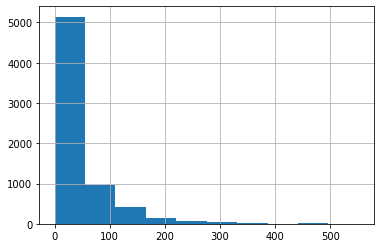

In [103]:
display(tmp.loc[(tmp['offer_type'] == 'informational') & (tmp['sub_offer_type'] == 'transaction'), 'time_diff_with_sub'].describe())

tmp.loc[(tmp['offer_type'] == 'informational') & (tmp['sub_offer_type'] == 'transaction'), 'time_diff_with_sub'].hist()
plt.show()

The median "response time" is 24 hours: what is the CR if we set this value as threshold?

In [104]:
threshold = 24

num = sum((tmp['offer_type'] == 'informational') & (tmp['sub_offer_type'] == 'transaction') & (tmp['time_diff_with_sub'] <= threshold))
den = sum(tmp['offer_type'] == 'informational')
print(f'There are {den} informational offers.')
print(f'There are {num} conversions with a response time of {threshold} hours.')
print(f'The Conversion Rate is {round((num / den) * 100, 2)}%.')

There are 9360 informational offers.
There are 3634 conversions with a response time of 24 hours.
The Conversion Rate is 38.82%.


## Customers portfolio

In [168]:
customers = df[['person', 'gender', 'age', 'income', 'member_on']].drop_duplicates()

display(customers.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person,14825,14825,30402635a14942bb8b108c5bc3509ce6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,14825,3,M,8484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,14825,NaN,NaN,NaN,54.3935,17.3837,18,42,55,66,101
income,14825,NaN,NaN,NaN,65405,21598.3,30000,49000,64000,80000,120000
member_on,14825,1707,2017-08-19,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN


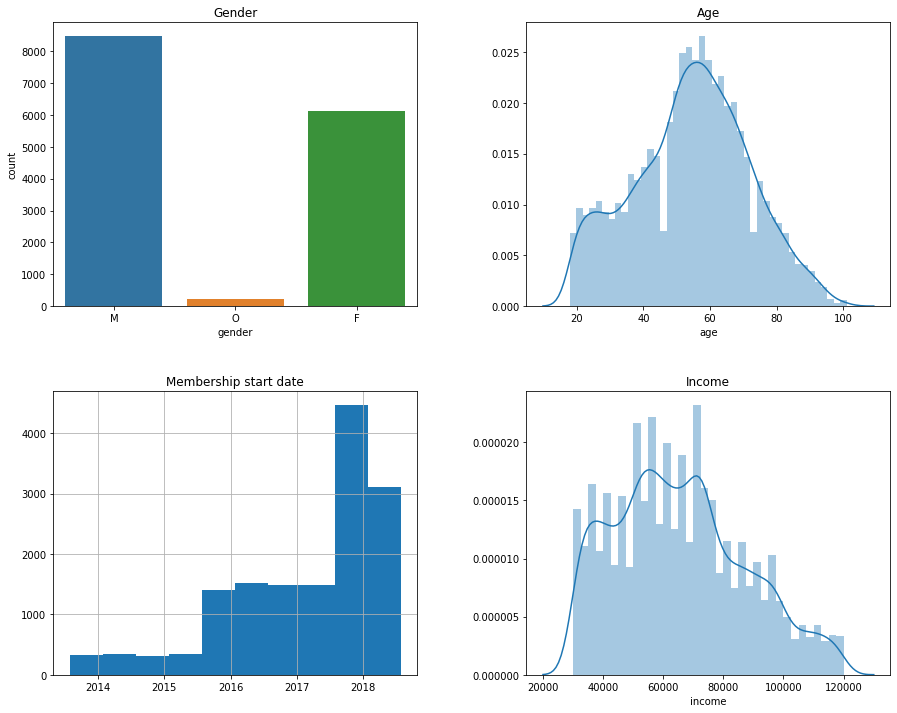


Membership start dates range from 2013-07-29 to 2018-07-26.



In [172]:
plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(221)
plt.title('Gender')
sns.countplot(x='gender', data=customers)

plt.subplot(222)
plt.title('Age')
sns.distplot(customers['age'])

plt.subplot(223)
plt.title('Membership start date')
customers['member_on'].hist()

plt.subplot(224)
plt.title('Income')
sns.distplot(customers['income'])

plt.show()


print('\nMembership start dates range from {} to {}.\n'.format(
    customers['member_on'].min().strftime('%Y-%m-%d'), customers['member_on'].max().strftime('%Y-%m-%d')
))

Some considerations:
- there is a third gender **O**, with very few records
- *age* has quite a normal distribution, while *income* has continuous spikes and has an irregular distribution
- the customers are quite new members, since the memberships are concentrated from the last part of 2017 onwards